### Estimator API

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow import keras
import pandas as pd

In [2]:
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [3]:
print(train_df.head())
print(eval_df.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


#### because the first column survived is to predicted value not a feature, so we must restruture the data

In [4]:
# dataframe pip function remove column from dataset and take the removed column
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())

      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]
      sex   age  n_siblings_spouses  parch  ...   class     deck  embark_town alone
0    male  35.0                   0      0  ...   Third  unknown  Southampton     y
1    male  54.0                   0      0  ...   First        E  Southampton     y
2  female  58.0                   0      0  ...   First        C  Southampton     y
3  female  55.0                   0      0  ...  Second  unknown  Southampton     y
4    male  34.0                   0      0  ...  Second     

In [5]:
train_df.describe() # show numeric data

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


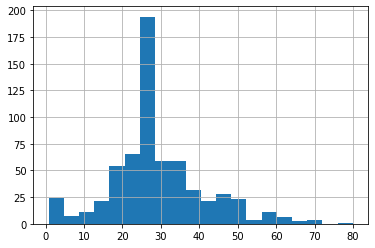

In [7]:
train_df.age.hist(bins = 20)

male      410
female    217
Name: sex, dtype: int64


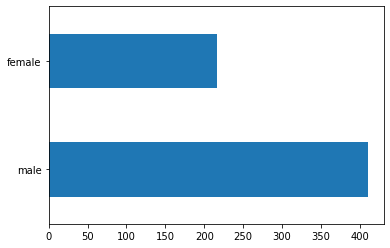

In [8]:
print(train_df.sex.value_counts())
train_df.sex.value_counts().plot(kind = 'barh')

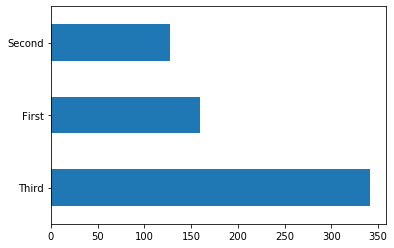

In [9]:
train_df['class'].value_counts().plot(kind = 'barh')

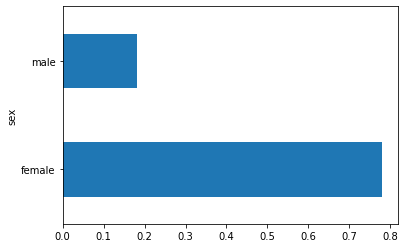

In [10]:
# from survived people, how many are male / femal?
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind = 'barh')

### Use tf.feature_column for loading data

In [11]:
# discrete value
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                      'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    
    print(categorical_column, vocab)
    
    feature_columns.append(
        # indicator_column -> one_hot discrete value
        tf.feature_column.indicator_column(
            # fill feature_column with vocab data (name, possible value)
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column,
                vocab)))

for numeric_column in numeric_columns:    
    feature_columns.append(
        # for numeric value just add them directly to feature_column
        tf.feature_column.numeric_column(numeric_column, dtype=tf.float32)
    )


sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


### Build Tensorflow Dataset

In [12]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    
    if shuffle == True:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [13]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

2019-07-24 09:28:29.288398: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-24 09:28:29.373942: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
2019-07-24 09:28:29.374394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x36ef440 executing computations on platform Host. Devices:
2019-07-24 09:28:29.374426: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>


In [14]:
for x, y in train_dataset.take(1):
    print(feature_columns[7])

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


### Build Layer with Dataset and DenseFeature

In [15]:
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())
    #print(keras.layers.DenseFeatures(age_column)(x).numpy())
    #print(keras.layers.DenseFeatures(gender_column)(x).numpy())

W0724 09:28:29.639090 140177708513088 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0724 09:28:29.671293 140177708513088 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0724 09:28:29.674238 140177708513088 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorf

[[37.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   9.5875  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [28.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   7.775   0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [24.      0.      1.      0.      0.      1.      0.      0.      0.
   0.      0.      0.      1.      0.      1.      0.      0.      0.
  13.      0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [30.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  24.15    1.      0.      0.      0.      0.      0.

In [26]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=feature_columns),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax')
])

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate=0.01),
              metrics = ["accuracy"])

### Here we got two options:
1. use model.fit 
2. use model -> estimator -> train

In [32]:
# 1. model.fit
train_dataset = make_dataset(train_df, y_train)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, 
                            shuffle=False)

history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 20,
                    validation_steps = 8,
                    epochs = 100)

Epoch 1/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5679 - accuracy: 0.7250 - val_loss: 0.5811 - val_accuracy: 0.6875
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5787 - accuracy: 0.6875 - val_loss: 0.5701 - val_accuracy: 0.6992
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5783 - accuracy: 0.6953 - val_loss: 0.6391 - val_accuracy: 0.6289
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5906 - accuracy: 0.6828 - val_loss: 0.5705 - val_accuracy: 0.7070
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5638 - accuracy: 0.7094 - val_loss: 0.5638 - val_accuracy: 0.7227
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6000 - accuracy: 0.6797 - val_loss: 0.5627 - val_accuracy: 0.7070
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.6812 - val_loss: 0.5701 - val_accuracy: 0.7031
Epoch 8/100
2

W0724 09:41:26.771472 140177708513088 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


In [35]:
# 2. use estimator (alternative to fit)
estimator = keras.estimator.model_to_estimator(model)

# input_fn -> must be a function i.g. a lambda function
# return 
# a. (features, labels)
# b. dataset(feature, label)
estimator.train(
    input_fn = lambda: make_dataset(train_df, y_train, epochs = 100)
)
# there is still a bug in tensorflow2-beta version... let's wait...

W0724 09:49:58.018241 140177708513088 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpckxctuz4
W0724 09:49:58.020351 140177708513088 keras.py:564] You are creating an Estimator from a Keras model manually subclassed from `Model`, that was already called on some inputs (and thus already had weights). We are currently unable to preserve the model's state (its weights) as part of the estimator in this case. Be warned that the estimator has been created using a freshly initialized version of your model.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.


KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_2', 'input_5', 'input_3', 'input_1', 'input_4', 'input_9', 'input_8', 'input_7', 'input_6'}\n\tfeatures keys: {'sex', 'fare', 'alone', 'parch', 'embark_town', 'class', 'deck', 'age', 'n_siblings_spouses'}\n\tDifference: {'sex', 'fare', 'input_2', 'input_5', 'parch', 'input_3', 'input_1', 'n_siblings_spouses', 'input_4', 'input_9', 'input_8', 'input_7', 'embark_town', 'input_6', 'class', 'alone', 'age', 'deck'}"